In [237]:
#pip install cookiecutter
!pip install yellowbrick

# Solution Planning

In [212]:
# Input

1. Business Problem

    Selecting the most valuable customers to join a fidelization program

2. Data

    E-commerce sales during a year

In [213]:
# Output

1. List of customer will be part of insider program

    client_id  |  is_insider
     10323     |  yes

In [214]:
# Task

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegivel? O que são clientes de maior 'valor'?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV
        - Baixa recência
        - Alto basket size
        - Baixa probabilidade de churn
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução
        
    - Experiencia de compra:
        - Média alta das avaliações
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características dos clientes:
        - Idade
        - Localização
        
    - Escrever características do consumo
        - Atributos de clusterizaçao

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise Cohort
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo
        
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa nao é ser similar ou parecido com uma pessoa grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferencia de compra
    - Visita a empresa

Benchmark de soluções

# Imports

In [215]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import cluster as c

# Helper Functions

# Data Import

In [216]:
#load data
df = pd.read_csv('Ecommerce.csv',encoding="ISO-8859-1")

#drop
df = df.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data Description

In [217]:
df1 = df.copy()

## 1.1. Rename Columns 

In [218]:
cols_new = df1.columns

cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2. Data Dimensions

In [219]:
print('Number of columns: ', df1.shape[1])
print('Number of rows: ', df1.shape[0])

Number of columns:  8
Number of rows:  541909


## 1.3. Data Type

In [220]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. NA Check

In [221]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [222]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('% dataset removed: {:.2f}'.format(1 - (df1.shape[0]/df.shape[0])))

% dataset removed: 0.25


## 1.6. Change Types

In [223]:
#df1['invoice_no'] = df1['invoice_no'].replace(to_replace='\D', value='', regex=True)
#df1['stock_code'] = df1['stock_code'].replace(to_replace='\D', value='0', regex=True)

In [224]:
#df1.loc[df1['stock_code'] == '85123A']
#df1 = df1.replace(['C536383','C536379','C536391','C536506'],['536383','536379','536391','536506'])

In [225]:
#invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format= '%d-%b-%y')

#customer id
df1['customer_id'] = df1['customer_id'].astype(int)

#invoice no
#df1['invoice_no'] = df1['invoice_no'].astype(int)

#stock code
#df1['stock_code'] = df1['stock_code'].astype(int)

## 1.7. Descriptive Statistics

# 2.0 Feature Engineering

In [226]:
df2 = df1.copy()

## 2.1. Feature Creation

In [227]:
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity',
              'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

#gross revenue
df2['gross_revenue'] = df2['quantity']*df2['unit_price']

#monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

#recency
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#frequency
df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# 3.0 Variable Filtering

In [228]:
df3 = df_ref.copy()

# 4.0 EDA

In [229]:
df4 = df3.copy()

# 5.0 Data Preparation

In [230]:
df5 = df4.copy()

# 6.0 Feature Selection

In [231]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning

In [232]:
X = df6.drop(columns = 'customer_id')

clusters = [2, 3, 4, 5, 6, 7, 8]

## 7.1 Within-Cluster Sum of Square (WSS)

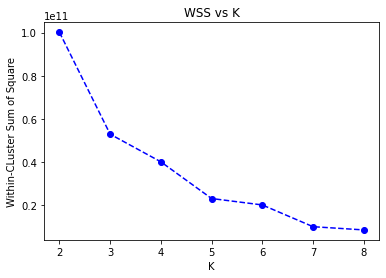

In [234]:
wss = []
for k in clusters:
    #model
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)

#plot wss - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-CLuster Sum of Square');
plt.title('WSS vs K');

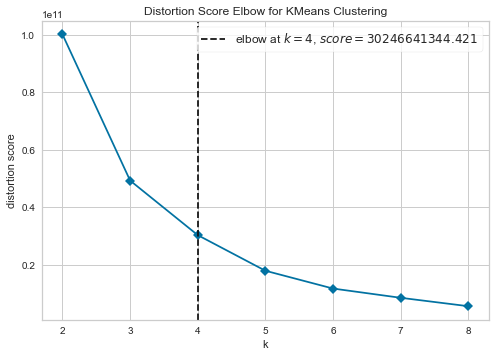

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [238]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings = False)
kmeans.fit(X)
kmeans.show()

# 3.0 Variable Filtering

# 3.0 Variable Filtering

# 3.0 Variable Filtering